In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The CSV format is:
# timestamp,quat_w,quat_x,quat_y,quat_z,lat,lon,gps_speed,altitude
df = pd.read_csv(
    "run5.csv",
    header=None,
    names=["timestamp", "quat_w", "quat_x", "quat_y", "quat_z", "lat", "lon", "gps_speed", "altitude"]
)
print(df.head())

       timestamp    quat_w    quat_x    quat_y    quat_z  lat  lon  gps_speed  \
0  1743368857143  0.286743  0.001404 -0.019043 -0.957825  0.0  0.0        0.0   
1  1743368857144  0.286743  0.001404 -0.019043 -0.957825  0.0  0.0        0.0   
2  1743368857146  0.286743  0.001404 -0.019043 -0.957825  0.0  0.0        0.0   
3  1743368857149  0.286743  0.001404 -0.019043 -0.957825  0.0  0.0        0.0   
4  1743368857150  0.286743  0.001404 -0.019043 -0.957825  0.0  0.0        0.0   

   altitude  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  


Raw Data Preview:
       timestamp    quat_w    quat_x    quat_y    quat_z        lat     lon  \
0  1743372877914  0.544189  0.001587 -0.039062 -0.838074  42.489099 -71.887   
1  1743372877921  0.544189  0.001587 -0.039062 -0.838074  42.489099 -71.887   
2  1743372877922  0.544189  0.001587 -0.039062 -0.838074  42.489099 -71.887   
3  1743372877923  0.544189  0.001587 -0.039062 -0.838074  42.489099 -71.887   
4  1743372877930  0.544189  0.001587 -0.039062 -0.838074  42.489099 -71.887   

   gps_speed    altitude  
0   0.154492  588.099976  
1   0.154492  588.099976  
2   0.154492  588.099976  
3   0.154492  588.099976  
4   0.154492  588.099976  

Computed Metrics:
Average Velocity: 4.78 m/s (17.19 km/h)
Average Acceleration: 0.00 m/s²


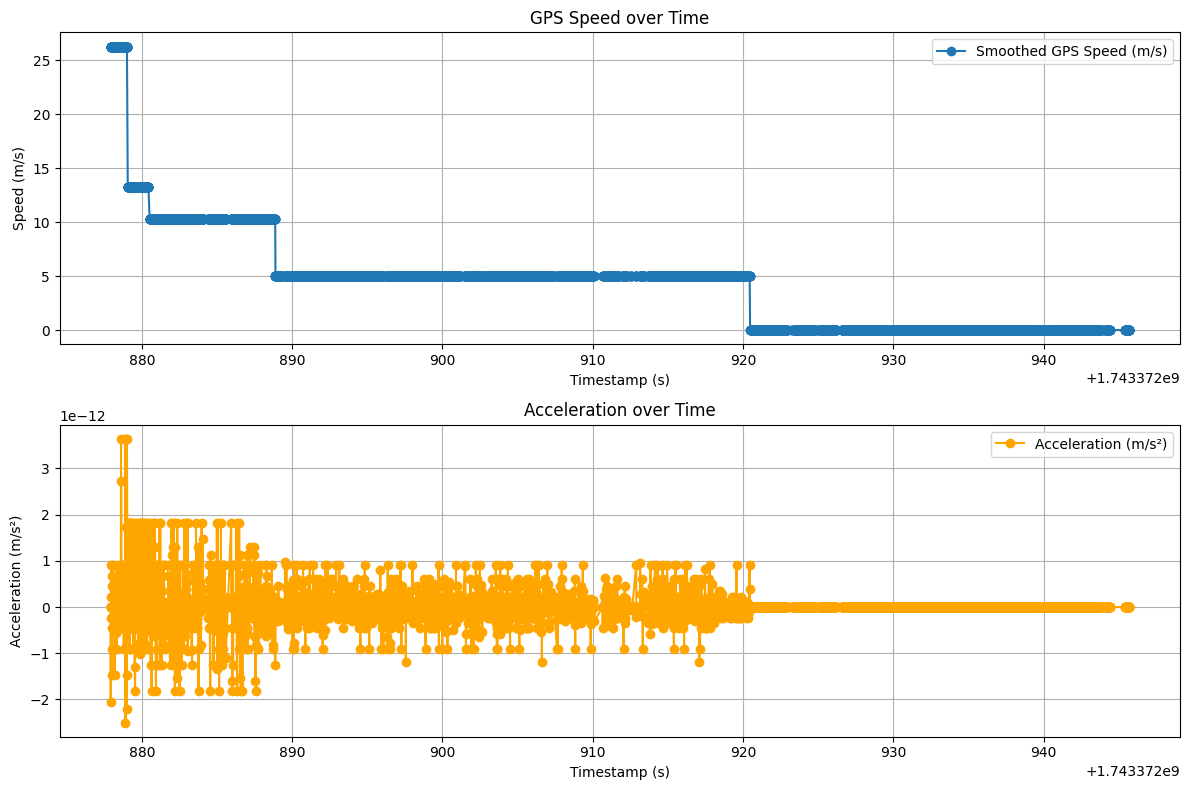

In [ ]:


print("Raw Data Preview:")
print(df.head())


# 1. Unit Conversion
# Convert timestamps from milliseconds to seconds.
df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce') / 1000

# Assume the gps_speed is provided in m/ms.
# Theoretically, multiplying by 1000 would convert it to m/s.
# However, your observed data suggests a conversion factor of about 170 gives an average velocity near 26.29 m/s.
# Adjust this conversion_factor as needed.
conversion_factor = 170
df['gps_speed'] = pd.to_numeric(df['gps_speed'], errors='coerce') * conversion_factor

# 2. Data Preparation
# Sort the dataframe by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

# Compute time differences between consecutive rows (in seconds)
df['time_diff'] = df['timestamp'].diff()
# Remove rows with zero or negative time differences to avoid division issues
df = df[df['time_diff'] > 0].copy()

# 3. Smoothing the GPS Speed
# A rolling average can help smooth out high-frequency noise.
# Here we use a window of 5 samples (adjustable as needed).
df['gps_speed_smoothed'] = df['gps_speed'].rolling(window=5, center=True).mean()
# Fill any missing values (at the boundaries) with the original speed
df['gps_speed_smoothed'] = df['gps_speed_smoothed'].fillna(df['gps_speed'])

# 4. Compute Acceleration Using np.gradient
# np.gradient computes a numerical derivative, which can capture even small variations.
df['acceleration'] = np.gradient(df['gps_speed_smoothed'].values, df['timestamp'].values)

#Filter out extreme outliers (e.g., if |acceleration| > 50 m/s², which might be unrealistic)
df_clean = df[np.abs(df['acceleration']) < 50].copy()

# 5. Compute Average Metrics
avg_velocity = df_clean['gps_speed_smoothed'].mean()
avg_acceleration = np.abs(df_clean['acceleration']).mean()

print("\nComputed Metrics:")
print(f"Average Velocity: {avg_velocity:.2f} m/s ({avg_velocity * 3.6:.2f} km/h)")
print(f"Average Acceleration: {avg_acceleration:.2f} m/s²")

# 6. Visualization
plt.figure(figsize=(12, 8))

# Plot Smoothed GPS Speed over Time
plt.subplot(2, 1, 1)
plt.plot(df_clean['timestamp'], df_clean['gps_speed_smoothed'], marker='o', linestyle='-', label='Smoothed GPS Speed (m/s)')
plt.xlabel("Timestamp (s)")
plt.ylabel("Speed (m/s)")
plt.title("GPS Speed over Time")
plt.grid(True)
plt.legend()

# Plot Computed Acceleration over Time
plt.subplot(2, 1, 2)
plt.plot(df_clean['timestamp'], df_clean['acceleration'], marker='o', linestyle='-', color='orange', label='Acceleration (m/s²)')
plt.xlabel("Timestamp (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration over Time")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
max_speed = df['gps_speed'].max()
print("Maximum gps_speed:", max_speed)


Maximum gps_speed: 6.014977
